# Preventive Medical Screening in Unborn

During the 5th week of gestation, a heartbeat-like **signal** can be detected in the embryo for the
first time. However, the unborn has to develop further for this signal to carry relevant medical
information. After the embryo evolved into a fetus, **heartbeat measurement can be a valuable
technique to measure fetal distress, avoid unecessary cesarean sections and detect pathologic
development** early on.

Based on inspection of frequency, amplitude and other properties of the fetal heartbeat, various diseases can be directly diagnosed or other investigative tools can be selected. However,
recording and isolating a clear signal in the maternal abdomen is tedious and requires complex machinery. Thus, an easier and more accessible method for recording is a **multi-electrode
system** that is placed to the mother’s abdomen. 

Combining the information provided by the
individual electrodes, digestive noise and maternal heartbeat can be **filtered out to obtain a
reliable fetal heartbeat signal**.

## Data Visualization

Synthetic maternal abdomen multi electrode ECG recordings

* Each file is an independent recording of a patient.
* Each file contains 4 electrodes and therefore 4 recorded channels.
* The sampling rate of each channel is 360 Hz.
* Some of the fetal heartbeat signals contain pathologies, try to detect them.

In [39]:
# Import all necessary dependencies (pleaes write new dependencies in this snippet.)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from scipy.signal import find_peaks, butter, filtfilt, freqz, stft

In [40]:

# load a data example
data = loadmat("Data/000.mat")

# Get the values from the mat file
values = data['val']

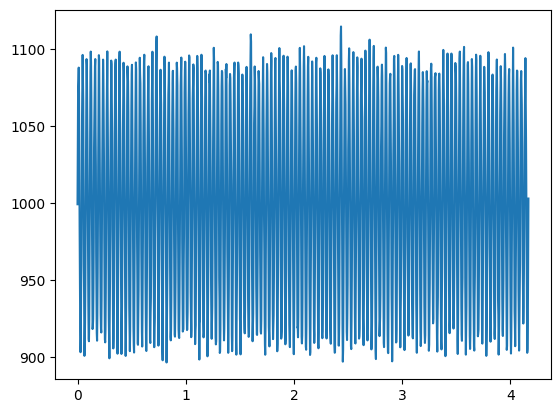

In [41]:
# Create the X and y datasets
y = values[0][0]
X = np.linspace(0, len(y)/360, len(y))


# Plot them
plt.figure()
plt.plot(X, y)
plt.show()

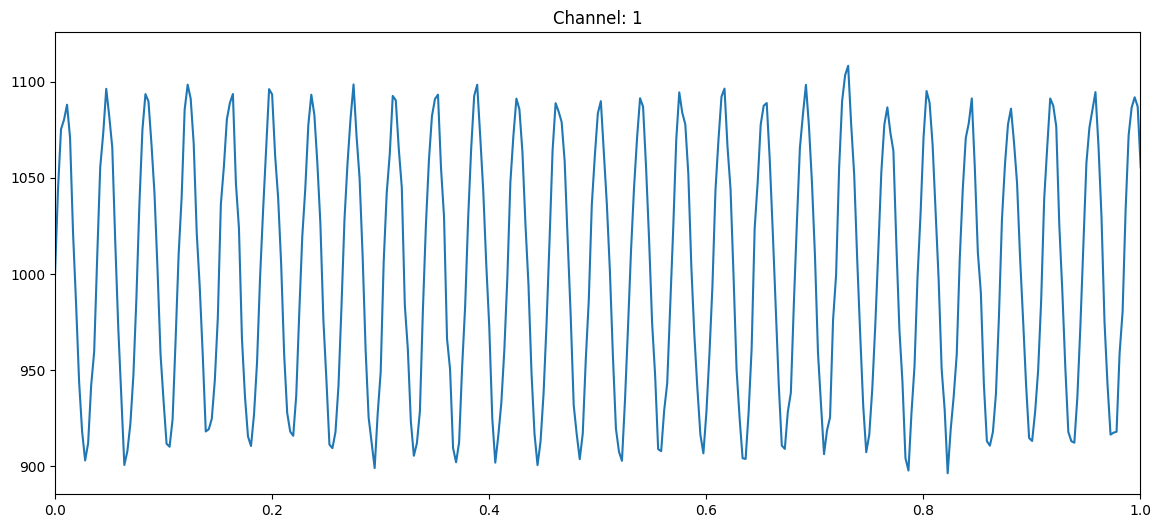

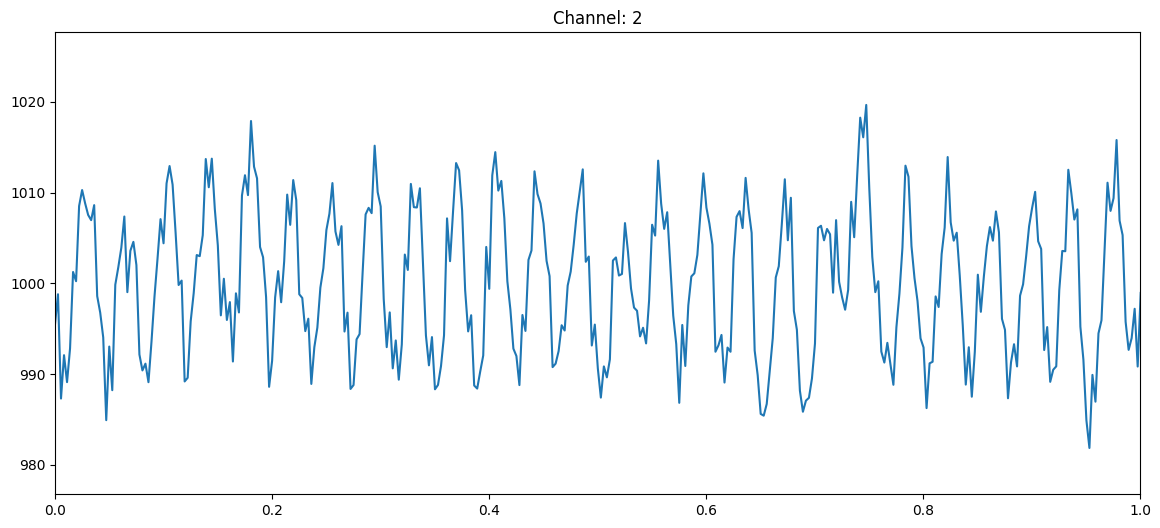

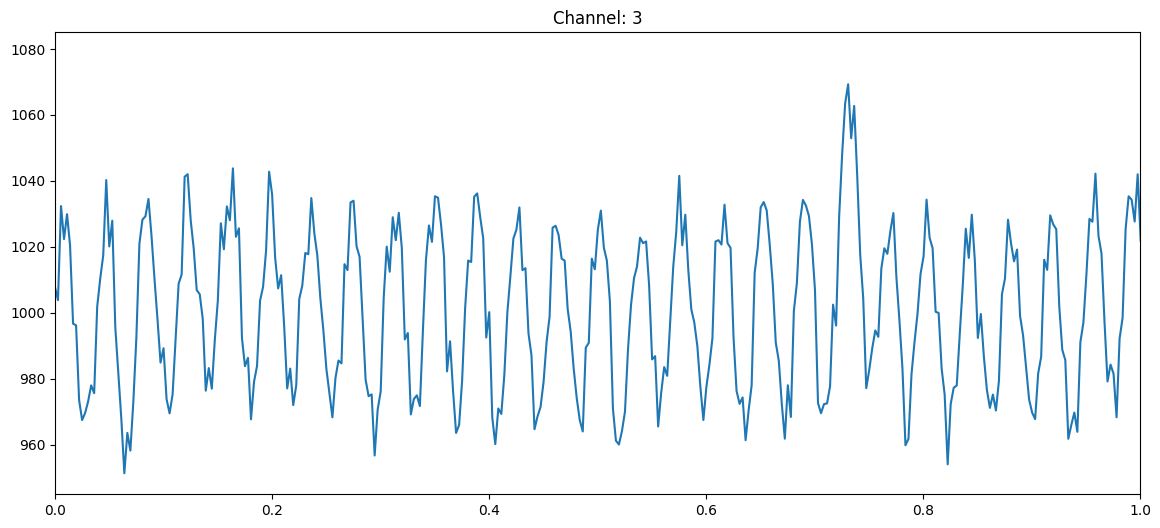

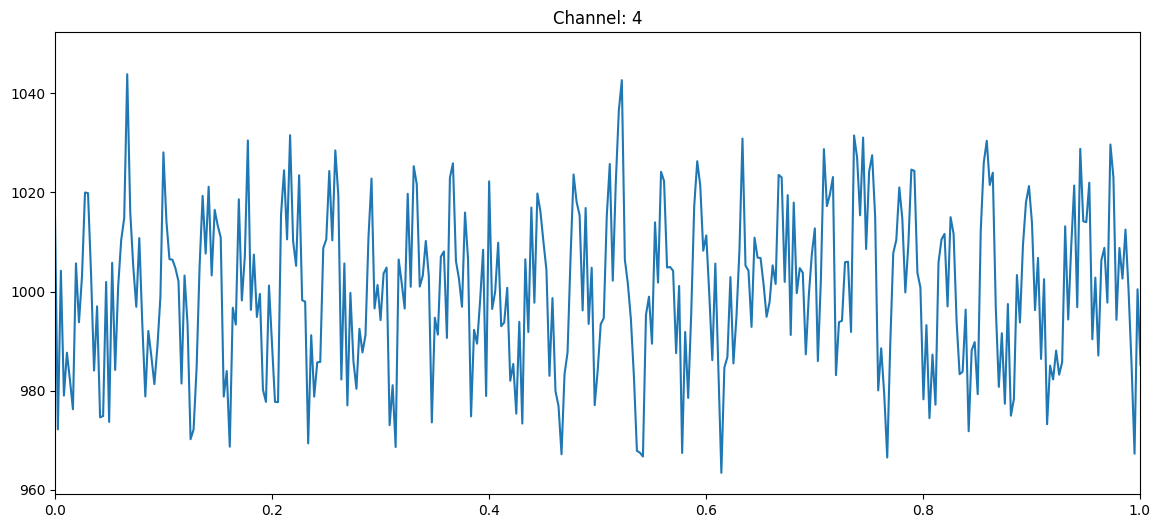

In [42]:
# Plot all the channels of one data

for i in range(0, 4):
    plt.figure(figsize=(14, 6))
    plt.plot(X, values[0][i])
    plt.title(f"Channel: {i+1}")
    plt.xlim([0, 1])
    plt.show()

In [43]:
# Calculate the differences
differences = np.diff(values[0][0])

# Identify local maxima
local_maxima = (differences[:-1] > 0) & (differences[1:] < 0)
local_maxima_indices = np.where(local_maxima)[0] + 1

# Count local maxima if needed
num_local_maxima = len(local_maxima_indices)
sampling = 360
t = len(values[0][0])/sampling
print(f"Frequency: {num_local_maxima/t} Hz")

Frequency: 27.36 Hz


This frequency is not comparable with the frequency of the mother's/fetus' heartbeat, which lie between **1-2 Hz** approximately.

## Preprocessing

### Filtering

In [44]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Design a Butterworth bandpass filter.

    Parameters:
    -----------
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.
    fs : float
        The sampling frequency of the signal in Hz.
    order : int, optional
        The order of the filter, which determines the steepness of the filter's 
        roll-off. Higher orders result in a sharper transition (default is 4).

    Returns:
    --------
    b, a : ndarray, ndarray
        The numerator (`b`) and denominator (`a`) coefficients of the IIR filter.
        
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [45]:
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies the Butterworth bandpass filter to the data.

    Parameters:
    -----------
    data : ndarray
        Raw data to be filtered.
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.
    fs : float
        The sampling frequency of the signal in Hz.
    order : int, optional
        The order of the filter, which determines the steepness of the filter's 
        roll-off. Higher orders result in a sharper transition (default is 4).

    Returns:
    --------
    y : ndarray
        Filtered data
        
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

The fetus heartbeat lies between 110-160 bpm which translates to approximately 1.8-2.7 Hz (https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fetal-heart-monitoring#:~:text=The%20average%20fetal%20heart%20rate,that%20there%20are%20other%20problems.). So the data has to be filtered in this range.

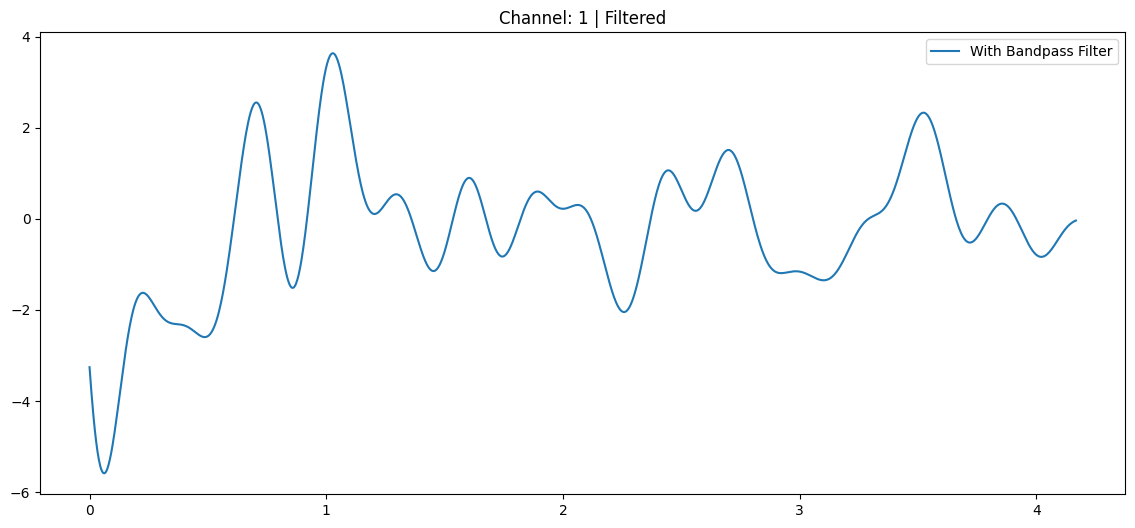

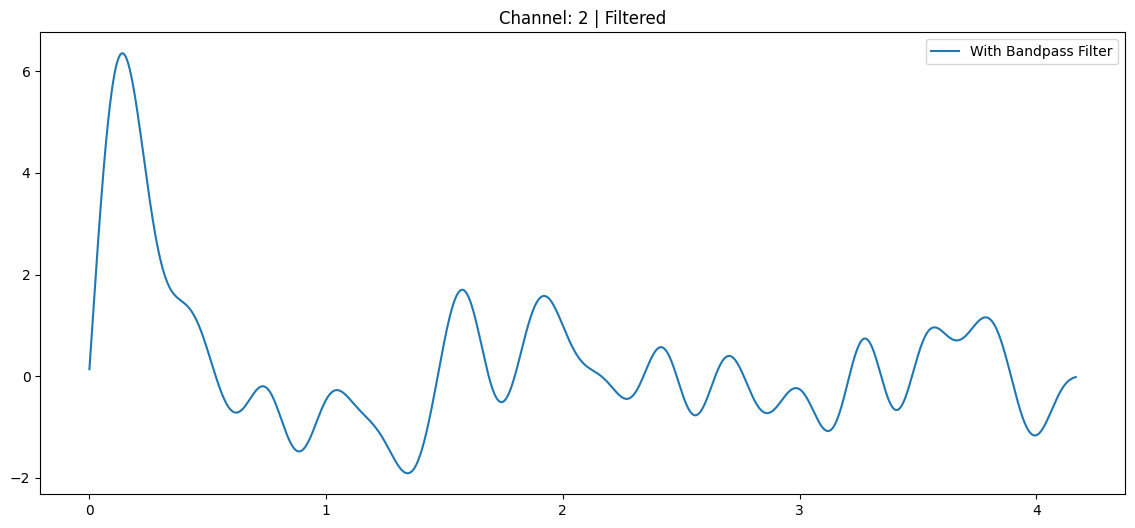

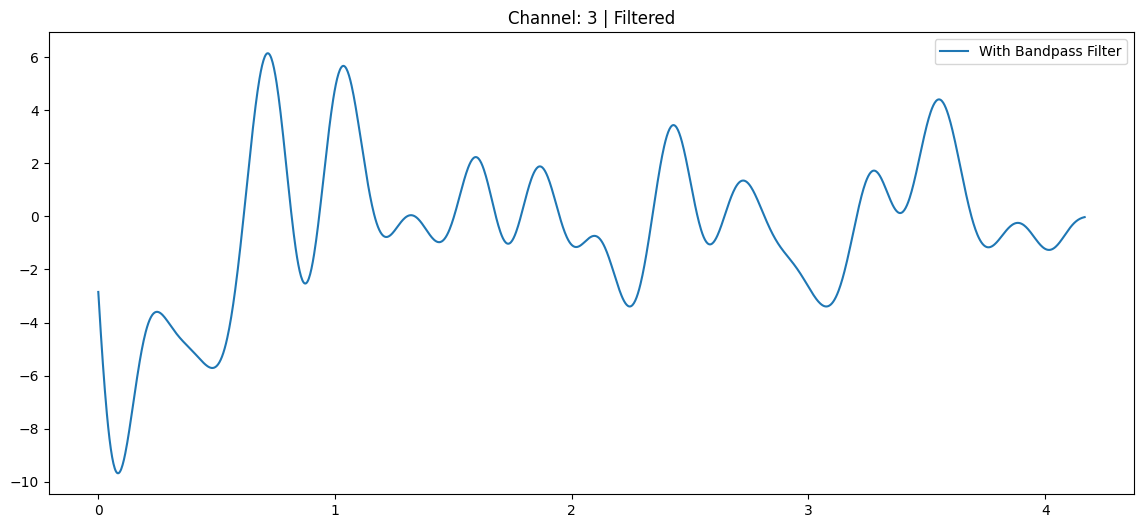

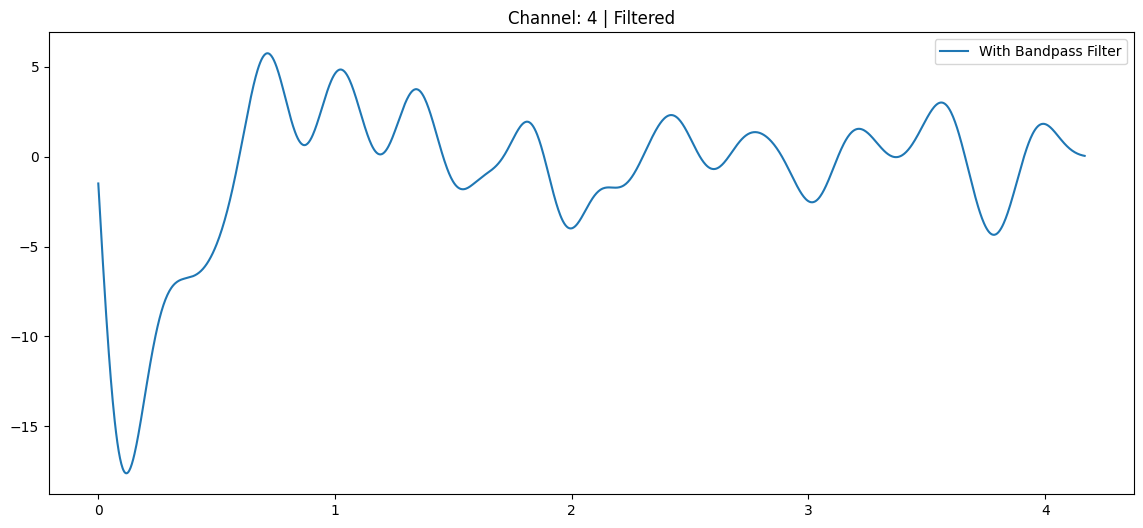

In [46]:
# Filter parameters
fs = 360  # Sampling frequency in Hz

# Choose the lowcut and highcut values to include the maternal and fetus heartbeats
lowcut = 0.5
highcut = 3.5  

X = np.linspace(0, len(values[0][0])/360, len(y))

for i in range(0, 4):
    filtered_signal = apply_bandpass_filter(values[0][i], lowcut, highcut, fs)
    plt.figure(figsize=(14, 6))
    # plt.plot(X, values[0][i], label="Without Bandpass Filter")
    plt.plot(X, filtered_signal, label="With Bandpass Filter")
    plt.title(f"Channel: {i+1} | Filtered")
    plt.legend()
    plt.show()

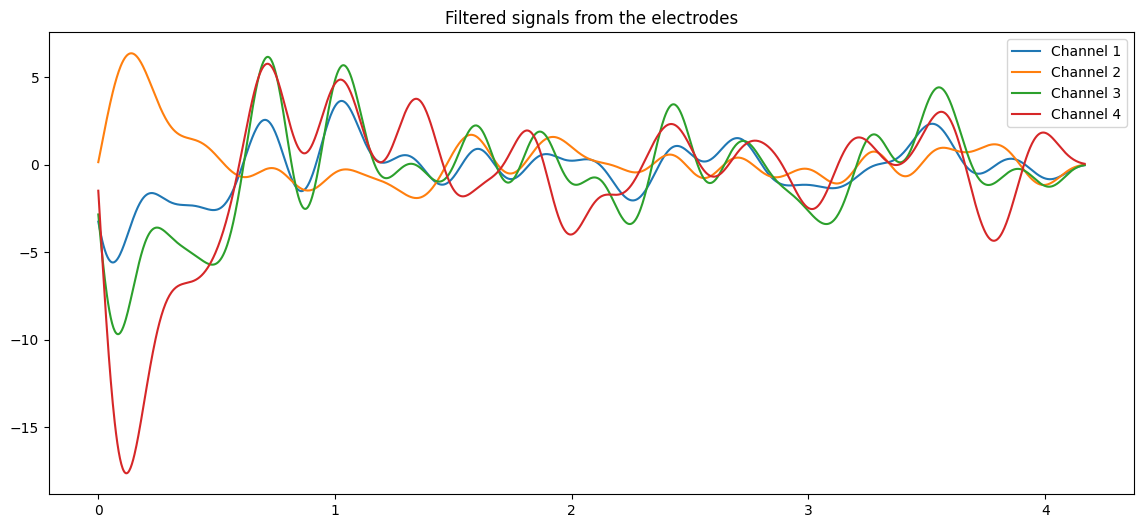

In [47]:
# Plot the four channels in a single plot

plt.figure(figsize=(14, 6))
for i in range(0, 4):
    filtered_signal = apply_bandpass_filter(values[0][i], lowcut, highcut, fs)
    plt.plot(X, filtered_signal, label=f"Channel {i+1}")
plt.title("Filtered signals from the electrodes")
plt.legend()
plt.show()

### Normalizing

In [48]:
def max_finder(data):
    """
    Finds the maximum value among a set of lists
    """
    maxv = 0
    for i in range(0, len(data)):
        temp_max = max(abs(data[i]))
        if temp_max > maxv:
            maxv = temp_max
    return maxv
        

def normalizer(data, maxv):
    """
    Normalizes the data to values between [-1, 1]
    """
    norm_data = data/maxv
    return norm_data

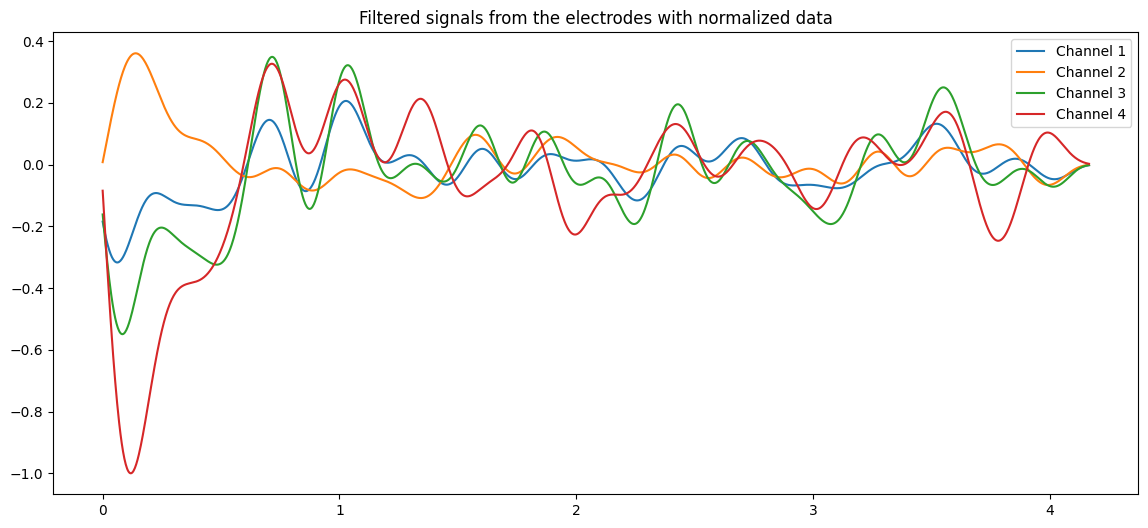

In [49]:
plt.figure(figsize=(14, 6))

# Instantiate empty list to store the filtered values
filtered_signals = []

# Append the filtered signals
for i in range(0, 4):
    fil_sgn = apply_bandpass_filter(values[0][i], lowcut, highcut, fs)
    filtered_signals.append(fil_sgn)

# Calculate the maximum among all lists
datamax = max_finder(filtered_signals)

for i in range(0, 4):
    normalized_signal = normalizer(filtered_signals[i], datamax)
    plt.plot(X, normalized_signal, label=f"Channel {i+1}")
plt.title("Filtered signals from the electrodes with normalized data")
plt.legend()
plt.show()

### STFT

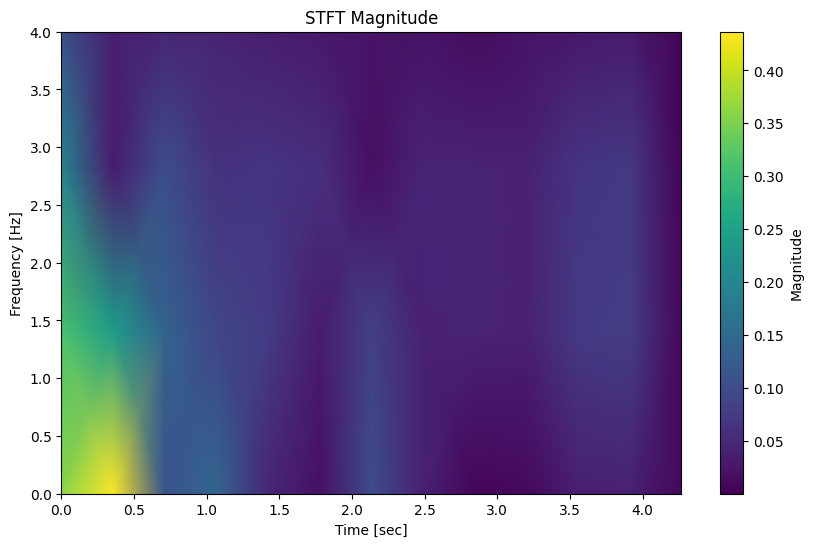

In [50]:
# Apply STFT
frequencies, times, Zxx = stft(normalized_signal, fs)

# Plotting the STFT magnitude
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 4])
plt.colorbar(label='Magnitude')
plt.show()

## Apply ICA

In [51]:
def apply_ica(path):

    """
    Applies ICA to the data

    Parameters:
    -----------
    path: string
        the path to the .mat file containing the recordings

    Returns:
    --------
    result: ndarray
        array of shape (4, recording length) with the signals after they were unmixed
        
    """


    data = loadmat(path)
    # apply ICA on data
    ica = FastICA()
    result = np.transpose(ica.fit_transform(np.transpose(values[0])))

    # Make sure that the amplitudes ar4e positives for consistency (sometimes ICA makes them negative)
    results = []
    for arr in result:
        if abs(np.min(arr)) > abs(np.max(arr)):
            arr = -arr
        results.append(arr)
            
    return np.array(results)

In [52]:
def post_process(result, lowcut, highcut, plot=True):

    """
    Post process the data by using the bandpass filter

    Parameters:
    -----------
    result : ndarray
        the result of ICA
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.

    Returns:
    --------
    result: ndarray
        an numpy array of shape (4, recording length) with the signals after they were filtered
        
    """

    # Filter parameters
    fs = 360  # Sampling frequency in Hz

    y = result[0]
    X = np.linspace(0, len(result[0])/360, len(y))

    results = []
    for i in range(0, 4):
        filtered_signal = apply_bandpass_filter(result[i], lowcut, highcut, fs)
        results.append(filtered_signal)
        if plot:
            plt.figure(figsize=(14, 6))
            # plt.plot(X, values[0][i], label="Without Bandpass Filter")
            plt.plot(X, filtered_signal, label="With Bandpass Filter")
            plt.title(f"Channel: {i+1} | Filtered")
            plt.legend()
            plt.show()

    return results

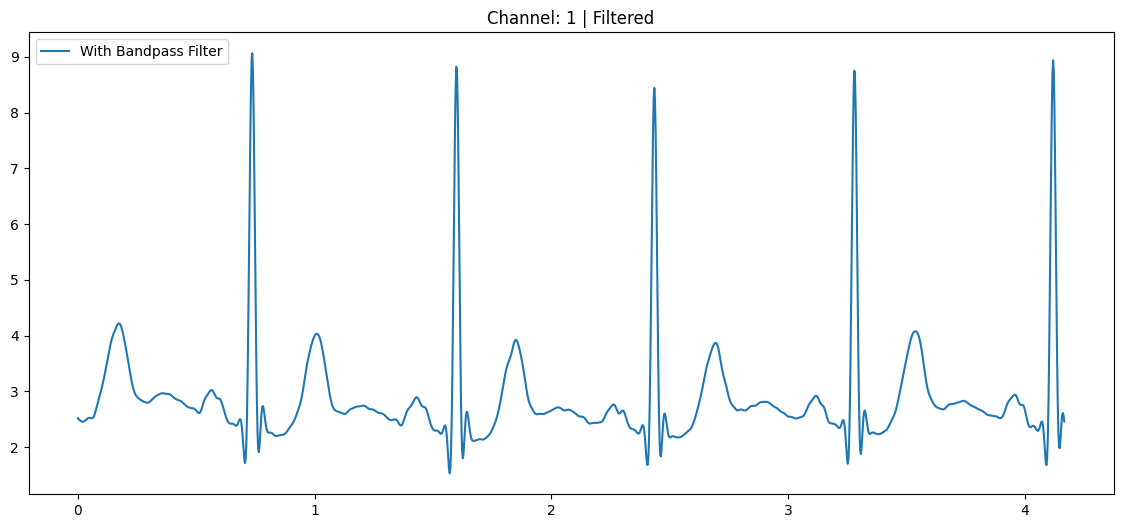

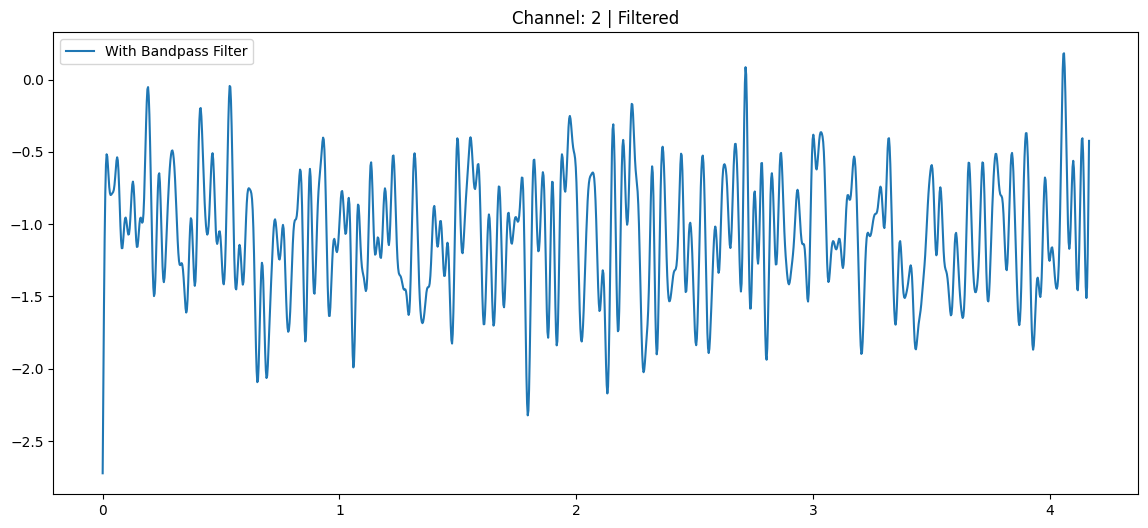

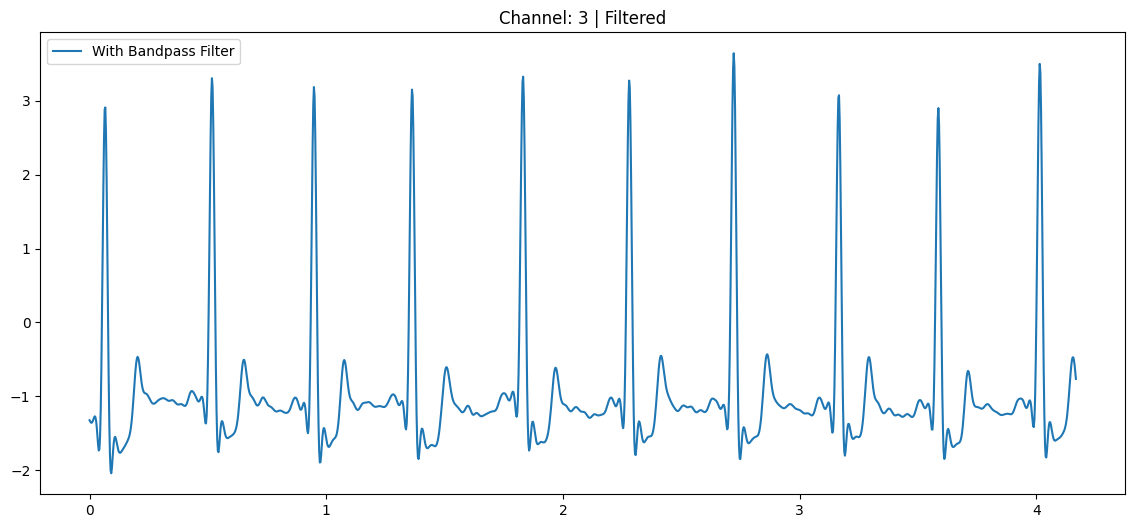

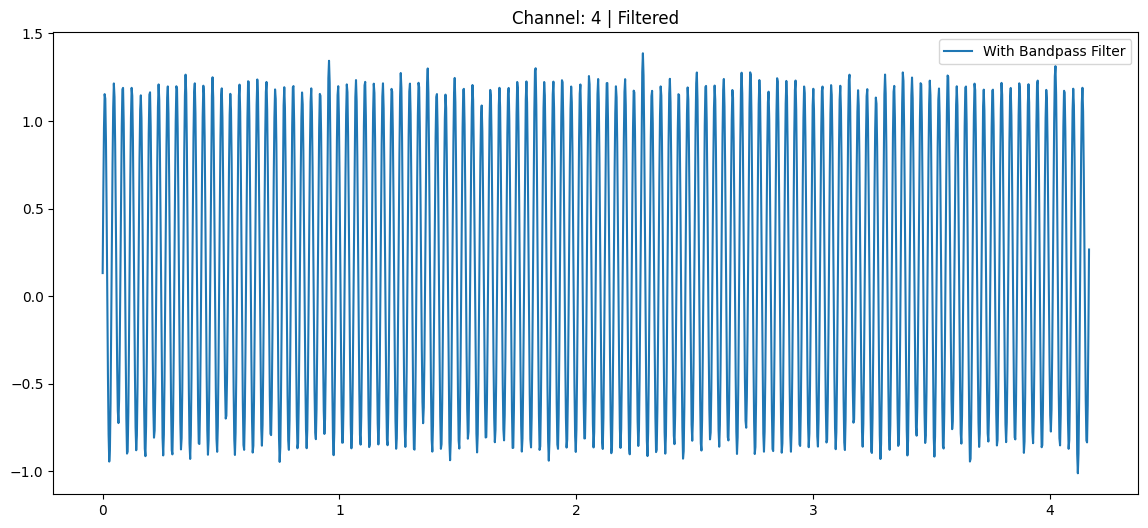

In [68]:
results = post_process(apply_ica("data/024.mat"), 0.0001, 30)

Two of the components returned by ICA resemble a heartbeat, while the other two contain other information or noise without noticeable spikes. Using this knowledge we can automatically filter for the two signals containing the heartbeats.

## Statistics

In [57]:
def calculate_statistics(data, threshold, sampling_rate, print_statistics=True):
    """
    Extracts local maxima from a continuous data stream if they exceed a specified threshold.
    Additionally, calculates the average frequency and standard deviation of these maxima.

    Args:
    data (iterable): The result of the post processing
    threshold (float): The minimum value for a local maximum to be considered.
    sampling_rate (float): The sampling rate of the data in Hz

    Returns:
    tuple: A tuple containing:
        - list of indices of maxima above the threshold,
        - list of values of maxima above the threshold,
        - average frequency of maxima (1 / average interval),
        - standard deviation of intervals between maxima.
    """  
    # Calculate the differences
    differences = np.diff(data)

    # Identify local maxima
    local_maxima = (differences[:-1] > 0) & (differences[1:] < 0)
    local_maxima_indices = np.where(local_maxima)[0] + 1

    # Filter local maxima according to threshold
    filtered_maxima = [data[idx] for idx in local_maxima_indices if data[idx] > threshold]
    filtered_indices = [idx for idx in local_maxima_indices if data[idx] > threshold]
    
    # Calculate mean and standard deviation for frequency
    intervals = np.diff(filtered_indices) / sampling_rate  # Convert samples to time intervals
    average_frequency = 1 / np.mean(intervals) if len(intervals) > 0 else 0
    std_frequency = np.std(intervals) if len(intervals) > 0 else 0
    
    # Calculate mean and standard deviation for amplitude
    average_amplitude = np.mean(filtered_maxima) if len(filtered_maxima) > 0 else 0
    std_amplitude = np.std(filtered_maxima) if len(filtered_maxima) > 0 else 0

    if print_statistics:
        print(f"Average heartbeat frequency: {average_frequency} Hz")
        print(f"Standard deviation of heartbeat frequency: {std_frequency} sec")
        print(f"Average heartbeat amplitude: {average_amplitude} ")
        print(f"Standard deviation of heartbeat amplitude: {std_amplitude} ")
        

    return filtered_indices, filtered_maxima, average_frequency, std_frequency, average_amplitude, std_amplitude

In [65]:
def show_statistics(data, sampling_rate, print_statistics=True):
    """
    Calculates and prints data regarding the heartbeat of the mother and embryo. This includes the average and standard deviation of the frequency and the amplitude of the heartbeat.
    
    Parameters:
        :param data: List of signals corresponding to different ICA components after postprocessing.
        :param sampling_rate: Sampling rate of the signal in Hz.
        :param print_statistics: Boolean flag to indicate whether to print the statistics or not.
    
    Returns:
    :return: A tuple containing the statistics of the mother and the embryo. Each element in the tuple is a list with relevant statistical measures.
    """
    # Get relevant statistics
    statistics = []
    for i, component in enumerate(data):
        threshold = np.mean(component) + 3 * np.std(component)
        component_statistics = calculate_statistics(component, threshold, sampling_rate, print_statistics=False)
        
        # Only take compoments with spikes above the threshold into consideration
        if component_statistics[2] != 0:
            statistics.append(component_statistics)
            
    # Sort by height of amplitudes and assume that the mother has a stronger heartbeat
    # Alternative: Assume that the embryo has a faster heartbeat
    statistics.sort(key=lambda x: x[4])
    stats_mother = statistics[1]
    stats_embryo = statistics[0]
    
    if print_statistics:
        # Print data of mother
        print("Statistics of the Mother:")
        print(f"Average heartbeat frequency: {stats_mother[2]} Hz")
        print(f"Standard deviation of heartbeat frequency: {stats_mother[3]} sec")
        print(f"Average heartbeat amplitude: {stats_mother[4]} ")
        print(f"Standard deviation of heartbeat amplitude: {stats_mother[5]} ")
        # Print data of embryo
        print("Statistics of the embryo")
        print(f"Average heartbeat frequency: {stats_embryo[2]} Hz")
        print(f"Standard deviation of heartbeat frequency: {stats_embryo[3]} sec")
        print(f"Average heartbeat amplitude: {stats_embryo[4]} ")
        print(f"Standard deviation of heartbeat amplitude: {stats_embryo[5]} ")
        
    return stats_mother, stats_embryo

In [69]:
stats = show_statistics(results, 360)

Statistics of the Mother:
Average heartbeat frequency: 1.1832374691865242 Hz
Standard deviation of heartbeat frequency: 0.009697388919283999 sec
Average heartbeat amplitude: 8.804425902090912 
Standard deviation of heartbeat amplitude: 0.2094740771321066 
Statistics of the embryo
Average heartbeat frequency: 2.2816901408450705 Hz
Standard deviation of heartbeat frequency: 0.01618532173102086 sec
Average heartbeat amplitude: 3.226635280365626 
Standard deviation of heartbeat amplitude: 0.22426596374996557 


The returned calculated values seem plausible for the previously mentions average heartbeat frequency.